# This is the notebook for DCGAN with PyTorch on CIFAR10 dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import all the packages and set the seed for reproducing

In [2]:
import os
import random

import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.utils as utils
from torch import optim
from torch.backends import cudnn
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

if not os.path.exists('./output'):
    os.makedirs('./output')
if not os.path.exists('./weights'):
    os.makedirs('./weights')

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# Enable the benchmark feature to improve the calculating efficiency
cudnn.benchmark = True
# set the manual seed
seed = 4471
random.seed(seed)
torch.manual_seed(seed)

## Load the dataset with the dataloader and set the device

In [5]:
# Load the data and set the dataloader
CIFAR10 = dataset.CIFAR10(root="./cifar10", download=True, transform=transforms.Compose(
    [transforms.Resize(64), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ]))
dataloader = DataLoader(CIFAR10, batch_size=512, shuffle=True, num_workers=4)

Files already downloaded and verified


In [6]:
# Set the cpu device
device = 'gpu' if torch.cuda.is_available() else 'cpu'

In [7]:
# number of discriminator channels
num_channel = 3
# noise dimension
num_z = 100
# generator filters
num_g_fil = 64
# discriminator filters
num_d_fil = 64

## Define the generator network

In [8]:
# The data initialization function for generator and discriminator
def initial_weights(net):
    if net.__class__.__name__.find('Conv') != -1:
        net.weight.data.normal_(0, 0.02)
    elif net.__class__.__name__.find('BatchNorm') != -1:
        net.weight.data.normal_(1.0, 0.02)
        net.bias.data.fill_(0)

In [9]:
# Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # First conv2d, input shape z
            nn.ConvTranspose2d(num_z, num_g_fil * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_g_fil * 8),
            nn.LeakyReLU(inplace=True),
            # Second conv2d, size num_g_fill*8 * 4 * 4
            nn.ConvTranspose2d(num_g_fil * 8, num_g_fil * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_g_fil * 4),
            nn.LeakyReLU(inplace=True),
            # Third conv2d, size num_g_fill*4 * 8 * 8
            nn.ConvTranspose2d(num_g_fil * 4, num_g_fil * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_g_fil * 2),
            nn.LeakyReLU(inplace=True),
            # Forth conv2d, size num_g_fill*2 * 16 * 16
            nn.ConvTranspose2d(num_g_fil * 2, num_g_fil * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_g_fil * 1),
            nn.LeakyReLU(inplace=True),
            # Fifth conv2d, size num_g_fill * 32 * 32
            nn.ConvTranspose2d(num_g_fil, num_channel, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output size num_channel * 64 * 64
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Initial the weights of generator and print the net detail
generator = Generator().to(device)
generator.apply(initial_weights)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): ConvT

## Define the discriminator network

In [11]:
# Class of discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input num_channel * 64 * 64
            nn.Conv2d(num_channel, num_d_fil, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.15, True),
            # second conv, num_d_fill * 32 * 32
            nn.Conv2d(num_d_fil, num_d_fil * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_d_fil * 2),
            nn.LeakyReLU(0.15, True),
            # third conv, num_d_fill*2 * 16 * 16
            nn.Conv2d(num_d_fil * 2, num_d_fil * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_d_fil * 4),
            nn.LeakyReLU(0.15, True),
            # forth conv, num_d_fill*4 * 8 * 8
            nn.Conv2d(num_d_fil * 4, num_d_fil * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_d_fil * 8),
            nn.LeakyReLU(0.15, True),
            # fifth conv, num_d_fill*8 * 4 * 4
            nn.Conv2d(num_d_fil * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [12]:
# Build the discriminator and print the detail
discriminator = Discriminator().to(device)
discriminator.apply(initial_weights)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.15, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.15, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.15, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.15, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Compile the network and set the training parameters

In [13]:
# Set the criterion and optimizer
criterion = nn.BCELoss()
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0004, betas=(0.5, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0004, betas=(0.5, 0.999))

In [14]:
# Set up training variables
noise = torch.randn(128, num_z, 1, 1, device=device)
real, fake = 1, 0
epochs = 65
from tqdm import tqdm
d_loss,g_loss=[],[]

## Start training!

In [15]:
for epoch in range(epochs):
    for i, data in enumerate(tqdm(dataloader), 0):
        discriminator.zero_grad()
        real_gpu = data[0].to(device)
        batch_size = real_gpu.size(0)
        label = torch.full((batch_size,), real, device=device).float()

        output = discriminator(real_gpu)
        d_error_real = criterion(output, label)
        d_error_real.backward()
        d_x = output.mean().item()

        noise = torch.randn(batch_size, num_z, 1, 1, device=device)
        fake_output = generator(noise)
        label.fill_(fake)
        output = discriminator(fake_output.detach())
        d_error_fake = criterion(output, label)
        d_error_fake.backward()
        d_g_1 = output.mean().item()
        err = d_error_fake + d_error_real
        discriminator_optimizer.step()

        generator.zero_grad()
        label.fill_(real)
        output = discriminator(fake_output)
        g_error = criterion(output, label)
        g_error.backward()
        d_g_2 = output.mean().item()
        generator_optimizer.step()

        # save the output
        if i % 97 == 0 and i != 0:
            print('Epoch: [%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, epochs,err.item(),
                                                                                                g_error.item(), d_x, d_g_1, d_g_2))
            d_loss.append(err.item())
            g_loss.append(g_error.item())
            print('saving the output')
            utils.save_image(real_gpu, 'output/real_samples.png', normalize=True)
            fake_output = generator(noise)
            utils.save_image(fake_output.detach(), 'output/fake_samples_epoch_{}.png'.format(epoch), normalize=True)
    
    torch.save(generator.state_dict(), 'weights/netG_epoch_{}.pth'.format(epoch))
    torch.save(discriminator.state_dict(), 'weights/netD_epoch_{}.pth'.format(epoch))
print("\n\nTraining Finished!\n\n")

 99%|█████████▉| 97/98 [10:30<00:06,  6.51s/it]

Epoch: [0/65] Loss_D: 0.6743 Loss_G: 2.7288 D(x): 0.6587 D(G(z)): 0.1316 / 0.0817
saving the output


 99%|█████████▉| 97/98 [10:32<00:06,  6.26s/it]

Epoch: [1/65] Loss_D: 2.2014 Loss_G: 1.1423 D(x): 0.2328 D(G(z)): 0.0107 / 0.3996
saving the output


 99%|█████████▉| 97/98 [10:47<00:06,  6.34s/it]

Epoch: [2/65] Loss_D: 0.3007 Loss_G: 3.9571 D(x): 0.9295 D(G(z)): 0.1860 / 0.0275
saving the output


 99%|█████████▉| 97/98 [10:31<00:06,  6.43s/it]

Epoch: [3/65] Loss_D: 0.8601 Loss_G: 2.5617 D(x): 0.7036 D(G(z)): 0.3361 / 0.1075
saving the output


 99%|█████████▉| 97/98 [10:36<00:06,  6.59s/it]

Epoch: [4/65] Loss_D: 1.0236 Loss_G: 4.8175 D(x): 0.7671 D(G(z)): 0.4599 / 0.0133
saving the output


 99%|█████████▉| 97/98 [10:37<00:06,  6.26s/it]

Epoch: [5/65] Loss_D: 0.7948 Loss_G: 4.2892 D(x): 0.7911 D(G(z)): 0.3691 / 0.0202
saving the output


 99%|█████████▉| 97/98 [10:42<00:06,  6.60s/it]

Epoch: [6/65] Loss_D: 0.6199 Loss_G: 2.8566 D(x): 0.6463 D(G(z)): 0.0730 / 0.0833
saving the output


 99%|█████████▉| 97/98 [10:41<00:06,  6.59s/it]

Epoch: [7/65] Loss_D: 1.0954 Loss_G: 4.9005 D(x): 0.9020 D(G(z)): 0.5476 / 0.0162
saving the output


 99%|█████████▉| 97/98 [10:31<00:06,  6.44s/it]

Epoch: [8/65] Loss_D: 0.8857 Loss_G: 3.3339 D(x): 0.7124 D(G(z)): 0.3576 / 0.0496
saving the output


 99%|█████████▉| 97/98 [10:50<00:06,  6.73s/it]

Epoch: [9/65] Loss_D: 0.7672 Loss_G: 2.6065 D(x): 0.6594 D(G(z)): 0.2219 / 0.1017
saving the output


 99%|█████████▉| 97/98 [10:40<00:06,  6.70s/it]

Epoch: [10/65] Loss_D: 0.9841 Loss_G: 0.6763 D(x): 0.4931 D(G(z)): 0.0868 / 0.5580
saving the output


 99%|█████████▉| 97/98 [10:37<00:06,  6.59s/it]

Epoch: [11/65] Loss_D: 0.9232 Loss_G: 4.4893 D(x): 0.8978 D(G(z)): 0.5017 / 0.0205
saving the output


 99%|█████████▉| 97/98 [10:34<00:06,  6.41s/it]

Epoch: [12/65] Loss_D: 1.0095 Loss_G: 1.0082 D(x): 0.4810 D(G(z)): 0.1151 / 0.4119
saving the output


 99%|█████████▉| 97/98 [10:42<00:06,  6.34s/it]

Epoch: [13/65] Loss_D: 0.6874 Loss_G: 1.7294 D(x): 0.6653 D(G(z)): 0.1906 / 0.2248
saving the output


 99%|█████████▉| 97/98 [10:27<00:06,  6.55s/it]

Epoch: [14/65] Loss_D: 0.8060 Loss_G: 2.8162 D(x): 0.8129 D(G(z)): 0.4107 / 0.0757
saving the output


 99%|█████████▉| 97/98 [10:40<00:06,  6.65s/it]

Epoch: [15/65] Loss_D: 0.6443 Loss_G: 2.0087 D(x): 0.6935 D(G(z)): 0.2001 / 0.1725
saving the output


 99%|█████████▉| 97/98 [10:42<00:06,  6.56s/it]

Epoch: [16/65] Loss_D: 0.9501 Loss_G: 3.1273 D(x): 0.8555 D(G(z)): 0.5023 / 0.0603
saving the output


 99%|█████████▉| 97/98 [10:34<00:06,  6.72s/it]

Epoch: [17/65] Loss_D: 0.8667 Loss_G: 3.8710 D(x): 0.9269 D(G(z)): 0.5082 / 0.0284
saving the output


 99%|█████████▉| 97/98 [10:28<00:06,  6.45s/it]

Epoch: [18/65] Loss_D: 0.7707 Loss_G: 3.8020 D(x): 0.8979 D(G(z)): 0.4446 / 0.0298
saving the output


 99%|█████████▉| 97/98 [10:37<00:06,  6.40s/it]

Epoch: [19/65] Loss_D: 0.6588 Loss_G: 2.2213 D(x): 0.7071 D(G(z)): 0.2330 / 0.1343
saving the output


 99%|█████████▉| 97/98 [10:48<00:06,  6.59s/it]

Epoch: [20/65] Loss_D: 0.8251 Loss_G: 2.7131 D(x): 0.7812 D(G(z)): 0.3987 / 0.0830
saving the output


 99%|█████████▉| 97/98 [10:28<00:06,  6.43s/it]

Epoch: [21/65] Loss_D: 1.1064 Loss_G: 1.6496 D(x): 0.6103 D(G(z)): 0.3831 / 0.2522
saving the output


 99%|█████████▉| 97/98 [10:30<00:06,  6.77s/it]

Epoch: [22/65] Loss_D: 1.0476 Loss_G: 0.7013 D(x): 0.4571 D(G(z)): 0.1292 / 0.5326
saving the output


 99%|█████████▉| 97/98 [10:36<00:06,  6.30s/it]

Epoch: [23/65] Loss_D: 0.7673 Loss_G: 2.0557 D(x): 0.7384 D(G(z)): 0.3334 / 0.1552
saving the output


 99%|█████████▉| 97/98 [10:40<00:06,  6.40s/it]

Epoch: [24/65] Loss_D: 0.4208 Loss_G: 3.2531 D(x): 0.8609 D(G(z)): 0.2182 / 0.0528
saving the output


 99%|█████████▉| 97/98 [10:39<00:06,  6.53s/it]

Epoch: [25/65] Loss_D: 1.2738 Loss_G: 0.9377 D(x): 0.4126 D(G(z)): 0.2243 / 0.4343
saving the output


 99%|█████████▉| 97/98 [10:36<00:06,  6.79s/it]

Epoch: [26/65] Loss_D: 1.2292 Loss_G: 3.3730 D(x): 0.9488 D(G(z)): 0.6403 / 0.0472
saving the output


 99%|█████████▉| 97/98 [10:40<00:06,  6.54s/it]

Epoch: [27/65] Loss_D: 0.6270 Loss_G: 2.0647 D(x): 0.5867 D(G(z)): 0.0508 / 0.1523
saving the output


 99%|█████████▉| 97/98 [10:39<00:06,  6.76s/it]

Epoch: [28/65] Loss_D: 2.1024 Loss_G: 5.8432 D(x): 0.9278 D(G(z)): 0.8342 / 0.0040
saving the output


 99%|█████████▉| 97/98 [10:37<00:06,  6.61s/it]

Epoch: [29/65] Loss_D: 1.3485 Loss_G: 1.1862 D(x): 0.5432 D(G(z)): 0.4662 / 0.3388
saving the output


 99%|█████████▉| 97/98 [10:39<00:06,  6.58s/it]

Epoch: [30/65] Loss_D: 1.2973 Loss_G: 2.5825 D(x): 0.7920 D(G(z)): 0.6060 / 0.0997
saving the output


 99%|█████████▉| 97/98 [10:44<00:06,  6.47s/it]

Epoch: [31/65] Loss_D: 0.9458 Loss_G: 2.9929 D(x): 0.7403 D(G(z)): 0.4356 / 0.0634
saving the output


 99%|█████████▉| 97/98 [10:40<00:06,  6.43s/it]

Epoch: [32/65] Loss_D: 0.2208 Loss_G: 3.6594 D(x): 0.9757 D(G(z)): 0.1724 / 0.0313
saving the output


 99%|█████████▉| 97/98 [10:31<00:06,  6.49s/it]

Epoch: [33/65] Loss_D: 1.1039 Loss_G: 0.9822 D(x): 0.5408 D(G(z)): 0.3122 / 0.4269
saving the output


 99%|█████████▉| 97/98 [10:26<00:06,  6.43s/it]

Epoch: [34/65] Loss_D: 1.0152 Loss_G: 1.2577 D(x): 0.4908 D(G(z)): 0.1994 / 0.3163
saving the output


 99%|█████████▉| 97/98 [10:32<00:06,  6.43s/it]

Epoch: [35/65] Loss_D: 1.2552 Loss_G: 1.1974 D(x): 0.5593 D(G(z)): 0.4161 / 0.3429
saving the output


 99%|█████████▉| 97/98 [10:36<00:06,  6.41s/it]

Epoch: [36/65] Loss_D: 0.8950 Loss_G: 3.2055 D(x): 0.8225 D(G(z)): 0.4736 / 0.0519
saving the output


 99%|█████████▉| 97/98 [10:48<00:06,  6.83s/it]

Epoch: [37/65] Loss_D: 0.8706 Loss_G: 1.6212 D(x): 0.6063 D(G(z)): 0.2605 / 0.2316
saving the output


 99%|█████████▉| 97/98 [10:37<00:06,  6.58s/it]

Epoch: [38/65] Loss_D: 1.0370 Loss_G: 1.4420 D(x): 0.5398 D(G(z)): 0.2864 / 0.2662
saving the output


 99%|█████████▉| 97/98 [10:29<00:06,  6.33s/it]

Epoch: [39/65] Loss_D: 0.8826 Loss_G: 2.8397 D(x): 0.7912 D(G(z)): 0.4341 / 0.0761
saving the output


 99%|█████████▉| 97/98 [10:31<00:06,  6.52s/it]

Epoch: [40/65] Loss_D: 1.1259 Loss_G: 1.0387 D(x): 0.4768 D(G(z)): 0.2609 / 0.3851
saving the output


 99%|█████████▉| 97/98 [10:36<00:06,  6.43s/it]

Epoch: [41/65] Loss_D: 0.1749 Loss_G: 3.5027 D(x): 0.9611 D(G(z)): 0.1224 / 0.0373
saving the output


 99%|█████████▉| 97/98 [10:33<00:06,  6.52s/it]

Epoch: [42/65] Loss_D: 0.9591 Loss_G: 1.4821 D(x): 0.6280 D(G(z)): 0.3461 / 0.2581
saving the output


 99%|█████████▉| 97/98 [10:31<00:06,  6.41s/it]

Epoch: [43/65] Loss_D: 0.9817 Loss_G: 1.4901 D(x): 0.6126 D(G(z)): 0.3456 / 0.2548
saving the output


 99%|█████████▉| 97/98 [10:42<00:06,  6.37s/it]

Epoch: [44/65] Loss_D: 0.8315 Loss_G: 1.4656 D(x): 0.8532 D(G(z)): 0.4314 / 0.2912
saving the output


 99%|█████████▉| 97/98 [10:42<00:06,  6.53s/it]

Epoch: [45/65] Loss_D: 1.2751 Loss_G: 1.1455 D(x): 0.5208 D(G(z)): 0.4033 / 0.3521
saving the output


 99%|█████████▉| 97/98 [10:39<00:06,  6.82s/it]

Epoch: [46/65] Loss_D: 2.3527 Loss_G: 0.9414 D(x): 0.1233 D(G(z)): 0.0495 / 0.4162
saving the output


 99%|█████████▉| 97/98 [10:39<00:06,  6.40s/it]

Epoch: [47/65] Loss_D: 0.7406 Loss_G: 2.2326 D(x): 0.6092 D(G(z)): 0.1233 / 0.1621
saving the output


 99%|█████████▉| 97/98 [10:36<00:06,  6.91s/it]

Epoch: [48/65] Loss_D: 1.4243 Loss_G: 2.1078 D(x): 0.8445 D(G(z)): 0.6735 / 0.1476
saving the output


 99%|█████████▉| 97/98 [11:09<00:06,  6.43s/it]

Epoch: [49/65] Loss_D: 0.8827 Loss_G: 2.7892 D(x): 0.8196 D(G(z)): 0.4576 / 0.0764
saving the output


 99%|█████████▉| 97/98 [10:38<00:06,  6.59s/it]

Epoch: [50/65] Loss_D: 0.8779 Loss_G: 2.3841 D(x): 0.7735 D(G(z)): 0.4275 / 0.1101
saving the output


 99%|█████████▉| 97/98 [10:27<00:06,  6.38s/it]

Epoch: [51/65] Loss_D: 0.7545 Loss_G: 1.9101 D(x): 0.6881 D(G(z)): 0.2833 / 0.1755
saving the output


 99%|█████████▉| 97/98 [10:26<00:06,  6.47s/it]

Epoch: [52/65] Loss_D: 0.8375 Loss_G: 2.6138 D(x): 0.7859 D(G(z)): 0.4034 / 0.0974
saving the output


 99%|█████████▉| 97/98 [10:25<00:06,  6.58s/it]

Epoch: [53/65] Loss_D: 0.5741 Loss_G: 3.1060 D(x): 0.8892 D(G(z)): 0.3435 / 0.0555
saving the output


 99%|█████████▉| 97/98 [10:33<00:06,  6.43s/it]

Epoch: [54/65] Loss_D: 2.8583 Loss_G: 1.8012 D(x): 0.9538 D(G(z)): 0.9210 / 0.2195
saving the output


 99%|█████████▉| 97/98 [10:34<00:06,  6.41s/it]

Epoch: [55/65] Loss_D: 0.6991 Loss_G: 1.9206 D(x): 0.7321 D(G(z)): 0.2903 / 0.1727
saving the output


 99%|█████████▉| 97/98 [10:29<00:06,  6.66s/it]

Epoch: [56/65] Loss_D: 0.7223 Loss_G: 1.6426 D(x): 0.5876 D(G(z)): 0.1148 / 0.2295
saving the output


 99%|█████████▉| 97/98 [10:33<00:06,  6.83s/it]

Epoch: [57/65] Loss_D: 1.4507 Loss_G: 6.7382 D(x): 0.9788 D(G(z)): 0.7163 / 0.0018
saving the output


 99%|█████████▉| 97/98 [10:38<00:06,  6.39s/it]

Epoch: [58/65] Loss_D: 1.0119 Loss_G: 1.6278 D(x): 0.6310 D(G(z)): 0.3458 / 0.2446
saving the output


 99%|█████████▉| 97/98 [10:34<00:06,  6.48s/it]

Epoch: [59/65] Loss_D: 0.9659 Loss_G: 2.4496 D(x): 0.8191 D(G(z)): 0.4915 / 0.1087
saving the output


 99%|█████████▉| 97/98 [10:30<00:06,  6.58s/it]

Epoch: [60/65] Loss_D: 0.7071 Loss_G: 1.8063 D(x): 0.7323 D(G(z)): 0.2987 / 0.1883
saving the output


 99%|█████████▉| 97/98 [10:32<00:06,  6.46s/it]

Epoch: [61/65] Loss_D: 0.6032 Loss_G: 2.2692 D(x): 0.8167 D(G(z)): 0.3073 / 0.1268
saving the output


 99%|█████████▉| 97/98 [10:31<00:06,  6.53s/it]

Epoch: [62/65] Loss_D: 0.3419 Loss_G: 2.6068 D(x): 0.8277 D(G(z)): 0.1258 / 0.0905
saving the output


 99%|█████████▉| 97/98 [10:35<00:06,  6.55s/it]

Epoch: [63/65] Loss_D: 0.9677 Loss_G: 1.9057 D(x): 0.6458 D(G(z)): 0.3626 / 0.1798
saving the output


 99%|█████████▉| 97/98 [10:29<00:06,  6.46s/it]

Epoch: [64/65] Loss_D: 0.8854 Loss_G: 1.4914 D(x): 0.6024 D(G(z)): 0.2622 / 0.2603
saving the output


100%|██████████| 98/98 [10:35<00:00,  6.48s/it]



Training Finished!




## Display our result on CIFAR10!
---
**Note that all the images are stored in the ./output folder and all the state dict of models are stored in the ./weights folder**

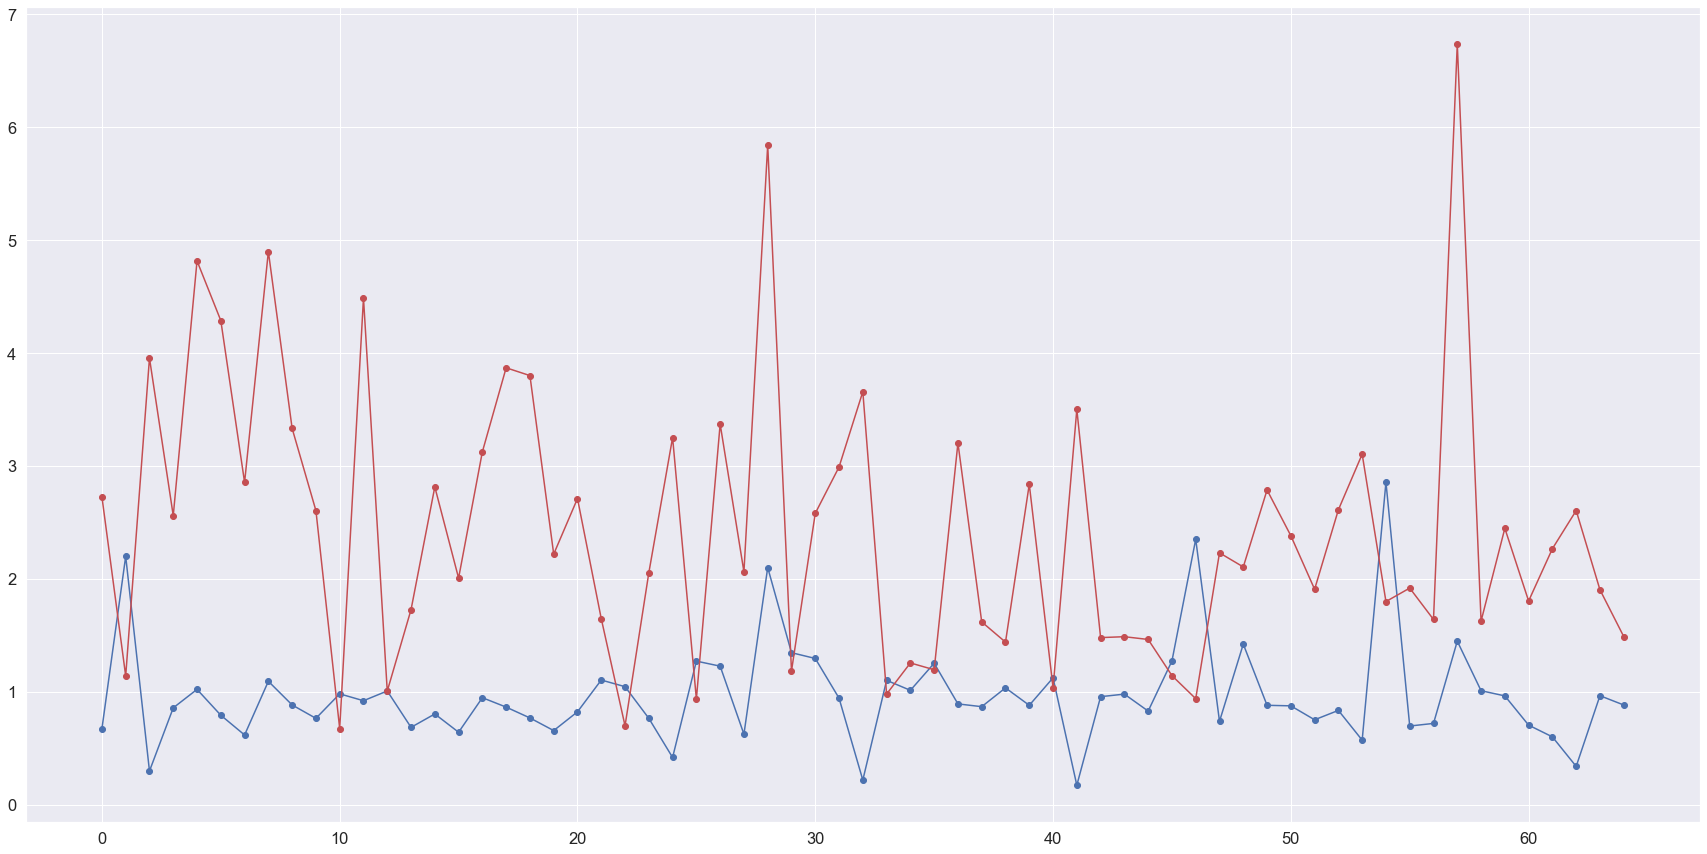

<Figure size 2160x1080 with 0 Axes>

In [16]:
# Plot the loss curve for generator and discriminator
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style="darkgrid")
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (30, 15)
plt.plot(d_loss,'b-o',label="Discriminator Loss")
plt.plot(g_loss,'r-o',label="Generator Loss")
plt.show()
plt.clf()
# The red is the Generator loss and the blue is the discriminator loss

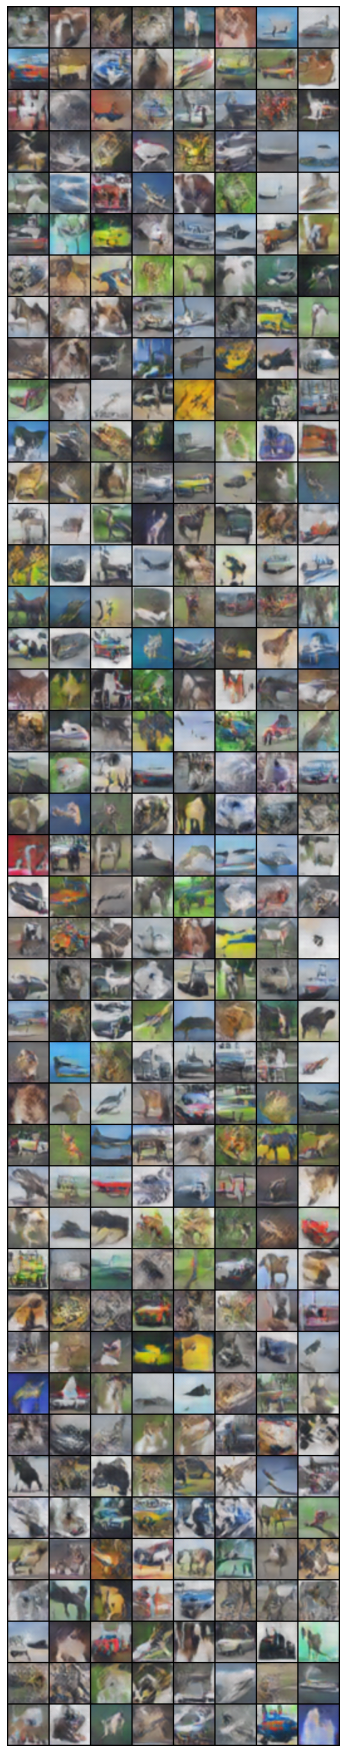

In [17]:
# Show the latest generated fake samples
from PIL import Image
plt.rcParams['figure.figsize'] = (64,32)
img=Image.open('./output/fake_samples_epoch_{}.png'.format(epochs-1))
plt.axis('off')
plt.imshow(img)